In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import matplotlib.pyplot as plt
from scripts.experiment_functions import kfold_experiments

# Read Data

Churn data

In [2]:
churn_data = arff.loadarff("data/chrun.arff")
churn_df = pd.DataFrame(churn_data[0])

Ok Cupid data

In [3]:
okcupid_stem = arff.loadarff("data/okcupid_stem.arff")
okcupid_df = pd.DataFrame(okcupid_stem[0])

### Small pre-processing. 

The columns **class** and **number_customer_service_calls** can be made ints

In [4]:
churn_df["class"] = churn_df["class"].astype(int)
churn_df["number_customer_service_calls"] = churn_df["number_customer_service_calls"].astype(int)

We replace **'?'** with nan values.
The income column is turned to float values

In [5]:
def determine_dtype(x):
    return x.decode("utf-8")
    

okcupid_df["job"] = okcupid_df["job"].apply(determine_dtype)

In [6]:
okcupid_df.replace(b'?', np.nan, inplace=True)
okcupid_df["income"] = okcupid_df["income"].astype('float64')

# Experiments

### Churn data experiments

Prepare parameters

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [8]:
# Data
X_churn = churn_df.drop(columns="class")
y_churn = np.reshape(churn_df["class"].values, X_churn.shape[0])

# Experiment parameters
kfolds = 5
scorer = "neg_log_loss"
ncores = 50
random_state = 42

# AutoML params
automl_dict = {"classification_algorithms": ["EL", "RF", "GB"],
               "numerical_strategies": ["SSE", "MMS"],
               "categorical_strategies": ["OHE", "SUM"],
               "test_fraction": 0.1,
               "cv_folds": 4,
               "random_state": random_state,
               "num_iterations": 4,
               "fidelity_parameter": 2,
               "n_jobs": ncores,
               "loss_function": scorer}

# Voters
voter_clfs = [RandomForestClassifier(random_state=random_state), 
              DecisionTreeClassifier(random_state=random_state),
              GradientBoostingClassifier(random_state=random_state)]

In [9]:
churn_experiment, churn_automl = kfold_experiments(X_churn, y_churn, kfolds, scorer, automl_dict, voter_clfs,
                                                  n_cores=ncores, random_state=42)

Fold 0


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:  50%|█████     | 2/4 [00:03<00:03,  1.89s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations: 100%|██████████| 4/4 [00:08<00:00,  2.07s/it]
Data-Model combinations: 1it [00:08,  8.27s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]
Data-Model combinations: 2it [00:18,  9.70s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it]
Data-Model combinations: 3it [00:24,  7.85s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
Data-Model combinations: 4it [00:29,  6.48s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]
Data-Model combinations: 5it [00:39,  7.87s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

Fold 1


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:  25%|██▌       | 1/4 [00:04<00:12,  4.06s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations:  50%|█████     | 2/4 [00:05<00:05,  2.79s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations:  75%|███████▌  | 3/4 [00:07<00:02,  2.12s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations: 100%|██

Fold 2


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:  50%|█████     | 2/4 [00:05<00:05,  2.76s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations:  75%|███████▌  | 3/4 [00:07<00:02,  2.15s/it]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

Hyperband iterations: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]
Data-Model combinations: 1it [00:08,  8.61s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]
Data-Model combinations: 2it [00:18,  9.50s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]
Data-Model combinations: 3it [00:24,  

Fold 3


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]
Data-Model combinations: 1it [00:11, 11.37s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]
Data-Model combinations: 2it [00:21, 10.41s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]
Data-Model combinations: 3it [00:26,  8.13s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
Data-Model combinations: 4it [00:30,  6.64s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]
Data-Model combinations: 5it [00:40,  7.72s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]
Data-Model combinations: 6it [00:45,  6.92s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]
Data-Model combinations: 7it [00:50,  6.19s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]
Data-Model combinations: 8it [01:00,  7.28s/it]
Hyperband iterations: 100%|█

Fold 4


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations: 100%|██████████| 4/4 [00:10<00:00,  2.50s/it]
Data-Model combinations: 1it [00:10, 10.01s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]
Data-Model combinations: 2it [00:19,  9.89s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it]
Data-Model combinations: 3it [00:25,  7.90s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
Data-Model combinations: 4it [00:29,  6.51s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]
Data-Model combinations: 5it [00:39,  7.66s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]
Data-Model combinations: 6it [00:44,  6.93s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]
Data-Model combinations: 7it [00:49,  6.20s/it]
Hyperband iterations: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]
Data-Model combinations: 8it [00:59,  7.29s/it]
Hyperband iterations: 100%|█

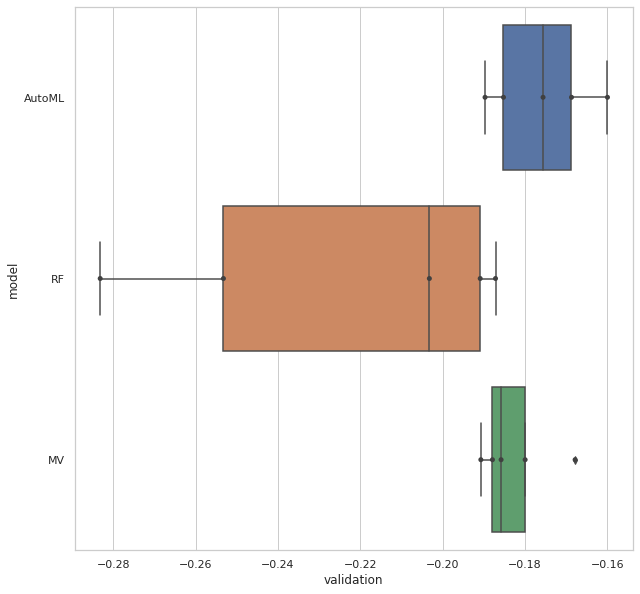

In [10]:
plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")
# plot boxplot
bp = sns.boxplot(x="validation", y="model", data=churn_experiment)
bp = sns.swarmplot(x="validation", y="model", data=churn_experiment, color=".25")
bp.get_figure().savefig("data/churn_results/base_boxplot.pdf", bbox_inches='tight')

In [11]:
churn_experiment.to_csv("data/churn_experiments.tsv.gz", sep='\t')
churn_automl.to_csv("data/churn_automl.tsv.gz", sep='\t')

In [14]:
churn_automl.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_C', 'param_l1_ratio',
       'param_max_iter', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'mean_train_score', 'std_train_score', 'hyperband_iter', 'combination',
       'param_bootstrap', 'param_criterion', 'param_max_depth',
       'param_max_samples', 'param_n_estimators', 'param_learning_rate',
       'param_subsample', 'champion', 'kfold'],
      dtype='object')

In [69]:
xdf = churn_automl.loc[(churn_automl["champion"] == "champion") & (churn_automl["hyperband_iter"] == 0),
             ["iter", "mean_test_score"]]

In [70]:
mean_iter = xdf.groupby("iter")["mean_test_score"].mean()

In [71]:
std_iter = xdf.groupby("iter")["mean_test_score"].std()

In [72]:
x = mean_iter.index

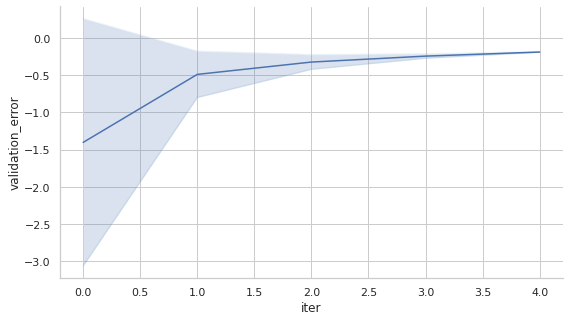

In [74]:
# Compute upper and lower bounds using chosen uncertainty measure: here
# it is a fraction of the standard deviation of measurements at each
# time point based on the unbiased sample variance
lower = mean_iter - std_iter
upper = mean_iter + std_iter

# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x, mean_iter, label='signal mean')
ax.plot(x, lower, color='tab:blue', alpha=0.1)
ax.plot(x, upper, color='tab:blue', alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)
ax.set_xlabel('iter')
ax.set_ylabel('validation_error')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [76]:
ax.get_figure().savefig("data/test.pdf", bbox_inches="tight")

In [53]:
jeje=xdf[["iter", "mean_test_score"]].drop_duplicates()

In [55]:
jeje

,iter,mean_test_score
0,0,-1.966284
1,0,-2.965653
2,0,-0.746925
3,0,-0.327636
4,0,-0.957811
...,...,...
26,2,-0.280345
27,2,-0.252690
28,3,-0.237237
29,3,-0.221183


ValueError: cannot reindex from a duplicate axis

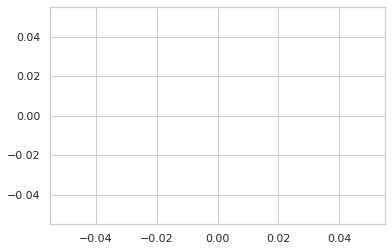

In [54]:
sns.lineplot(x="iter", y="mean_test_score", data=jeje)

ValueError: cannot reindex from a duplicate axis

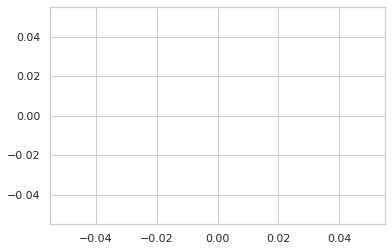

In [44]:
sns.lineplot(x="iter", y="mean_test_score", data=xdf, units="kfold")

Okcupid experiments

In [8]:
# Data
X_cupid = okcupid_df.drop(columns="job")
y_cupid = np.reshape(okcupid_df["job"].values, X_cupid.shape[0])

In [9]:
X_cupid.shape

(50789, 19)

In [10]:
# Experiment parameters
kfolds = 10
scorer = "neg_log_loss"
ncores = 80
random_state = 42

# AutoML params
automl_dict = {"classification_algorithms": ["DT", "RF", "GB"],
               "numerical_strategies": ["SSE", "MMS"],
               "categorical_strategies": ["OHE", "SUM"],
               "test_fraction": 0.3,
               "cv_folds": 3,
               "random_state": random_state,
               "num_iterations": 4,
               "fidelity_parameter": 4,
               "n_jobs": ncores,
               "loss_function": scorer,
               "n_estimators": 10}

# Voters
voter_clfs = [RandomForestClassifier(random_state=random_state), 
              DecisionTreeClassifier(random_state=random_state),
              GradientBoostingClassifier(random_state=random_state)]

In [11]:
cupid_experiment, cupid_automl = kfold_experiments(X_cupid, y_cupid, kfolds, scorer, automl_dict, voter_clfs,
                                                  n_cores=ncores, random_state=42)

Fold 0


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan -4.24381955 -3.13221726
 -2.71329363]
  category=UserWarning

Hyperband iterations: 100%|██████████| 4/4 [00:30<00:00,  7.52s/it]
Data-Model combinations: 1it [00:30, 30.09s/it]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or 

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  -2.56594334  -0.7778307  -20.87584678]
  category=UserWarning

Hyperband iterations: 100%|██████████| 4/4 [03:40<00:00, 55.19s/it]
Data-Model combinations: 9it [14:06, 115.32s/it]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan 

Fold 1


Data-Model combinations: 0it [00:00, ?it/s]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan -6.1739257 -4.4939458
 -3.1794911]
  category=UserWarning

Hyperband iterations: 100%|██████████| 4/4 [00:32<00:00,  8.04s/it]
Data-Model combinations: 1it [00:32, 32.16s/it]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the t

/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
  -2.31066429  -0.75724017 -20.94520175]
  category=UserWarning

Hyperband iterations: 100%|██████████| 4/4 [03:39<00:00, 54.86s/it]
Data-Model combinations: 9it [14:10, 115.27s/it]
Hyperband iterations:   0%|          | 0/4 [00:00<?, ?it/s]/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning
/home/roberto_olayo/miniconda3/envs/automl/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan 

KeyboardInterrupt: 

In [ ]:
cupid_experiment.to_csv("data/cupid_experiment.tsv.gz", sep='\t')
cupid_automl.to_csv("data/cupid_experiment.tsv.gz", sep='\t')